# Project #3 - Neural Nets

### Step 1

Choose three data series, one of which should be the USD-to-Yen exchange rate.  Other series can be interest rates, stock indices, or other exchange rate series.  Use at least 20 years of data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt


The following series are obtained from FRED database to build our datasets:
1. Japanese Yen to U.S. Dollar Spot Exchange Rate (DEXJPUS)
2. U.S. Dollars to Euro Spot Exchange Rate (DEXUSEU)
3. 10-YEARS U.S. Treasury Yield (DGS10)

The reason we chose these three is because we believe that having another exchange rate series to compare with USD to YEN will be very interesting, and adding the 10 years treasury rate can help us to explore the trends and effects from monetary policies and market fluctuation.

In [ ]:
start_date = '2000-01-01'
end_date = dt.date.today() - pd.Timedelta(days=1)

series_ids = {'DEXJPUS': 'FX_USD_to_YEN',
              'DEXUSEU': 'FX_USD_to_EUR',
              'DGS10': 'US_Treasury_10Y'}

data = pd.DataFrame()

for series_id, series_name in series_ids.items():
    df = web.DataReader(series_id, 'fred', start_date, end_date)
    df.rename(columns={series_id: series_name}, inplace=True)
    data = pd.concat([data, df], axis=1)

for col in data.columns:
    data[col].fillna(method='ffill', inplace=True)

data.dropna(axis=0, how='all', inplace=True)

print(f'\nThere are {len(data):,} days in the dataset\n')


There are 6,504 days in the dataset



<ipython-input-2-222af1dfc57f>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(method='ffill', inplace=True)
<ipython-input-2-222af1dfc57f>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method='ffill', inplace=True)


In [ ]:
data.head()

,FX_USD_to_YEN,FX_USD_to_EUR,US_Treasury_10Y
DATE,,,
2000-01-03,101.70,1.0155,6.58
2000-01-04,103.09,1.0309,6.49
2000-01-05,103.77,1.0335,6.62
2000-01-06,105.19,1.0324,6.57
2000-01-07,105.17,1.0294,6.52


In [ ]:
data.tail()

,FX_USD_to_YEN,FX_USD_to_EUR,US_Treasury_10Y
DATE,,,
2024-11-29,150.41,1.0547,4.18
2024-12-02,150.41,1.0547,4.19
2024-12-03,150.41,1.0547,4.23
2024-12-04,150.41,1.0547,4.19
2024-12-05,150.41,1.0547,4.17


# Step 2 – Recurrent Neural Networks

Create a neural net to forecast your data series out to two weeks (10 days).  The first layer should have two RNNs.  Feed at least two series into one of the RNNs and at least one into the other.  The second layer will only have one RNN, receiving the outputs from the first layer.  The third layer should have only a few linear nodes with SoftPlus activations (no more than five).  The final layer should have three nodes, all linear with no activations.

By having the second layer of RNNs, it should be possible to capture more complex aspects of the time series.

Try to keep the number of parameters low. Use AI to count them and report how many there are.
Explain why you chose the series that you chose.
Make sure to comment on the model’s ability to forecast.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn

Here we scale the data using MinMaxScaler and create sequence for observations.

In [ ]:
scaler = MinMaxScaler()
scalers = {}
data_scaled = data.copy()

for col in data_scaled.columns:
    data_scaled[col] = scaler.fit_transform(data_scaled[[col]])
    scalers[col] = scaler


We want to use the past one-month data (22 business days) to predict the two-weeks data (10 business days). 

Similar to the example (Complex RNN), our y is the difference of forecast value - the last value in the sequence. The last value is reserved to be added back.

In [ ]:
def create_sequences(data, seq_length = 22, target_step= 10):
    xs = []
    ys = []
    lvs = []
    for i in range(len(data) - seq_length - target_step):
      x = data.iloc[i:(i + seq_length)].values
      y = data.iloc[i + seq_length + target_step - 1].values - data.iloc[i + seq_length - 1].values
      xs.append(x)
      ys.append(y)
      last_values = data.iloc[i + seq_length - 1].values
      lvs.append(last_values)
    return np.array(xs), np.array(ys), np.array(lvs)

seq_length = 22
target_step = 10
x, y, lvs = create_sequences(data_scaled, seq_length=seq_length, target_step=target_step)

print(f"Input sequences shape: {x.shape}")
print(f"Targets shape: {y.shape}")
print(f"Last values shape: {lvs.shape}")

Input sequences shape: (6472, 22, 3)
Targets shape: (6472, 3)
Last values shape: (6472, 3)


Now we split the data into train/test datasets and convert the datasets to tensors. We apply the 80 to 20 ratio between the train and test datasets and cobmbine the list of tensors into a single train/test tensor using torch.cat.

We encountered an error when running the code after we finished the model and started testing. Because originally we were using:

X_train_rnn = [X_train[:, :, i].unsqueeze(-1) for i in range(3)]

which made the X_train_rnn a list of tensors instead of a single tensor.

Then, we asked ChatGPT to debug for us by asking " how should I convert a list of tensor into single tensor" following the error code, and chatgpt provided torch.cat as solution.

In [ ]:
train_size = int(len(x) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]
lv_test = lvs[train_size:]

X_train = torch.tensor(x_train, dtype=torch.float32) # We used capital X and Y here to differentiate tensors and original arrays.
Y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(x_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

X_train_rnn = torch.cat([X_train[:, :, i].unsqueeze(-1) for i in range(3)], dim=-1) # Corrected by using torch.cat
X_test_rnn = torch.cat([X_test[:, :, i].unsqueeze(-1) for i in range(3)], dim=-1)

In [ ]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([5177, 22, 3]), Y_train shape: torch.Size([5177, 3])
X_test shape: torch.Size([1295, 22, 3]), Y_test shape: torch.Size([1295, 3])


Here we initialize the RNN model.

First layer:

we have 2 seperate RNNs: self.rnn_first_1 and self.rnn_first_2,

the first rnn takes 2 inputs of the 2 exchange rate series and the second rnn takes only 1 input of the treasury rate series.

Second layer:

We set up a single RNN that combines the output from the first layer RNNs as input(hidden_size * 2), which generates outputs for the third layer.

Third layer & Output layer:

We have a linear RNN of 5 nodes with activation function Softplus in the third layer and a linear RNN with no activation function for the output layer.

The forward functions ensure the correct input for each layer and generate the final output.




In [ ]:
class RNN_model(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, hidden_layer_size=2, hidden_nodes_size=5, output_size=3):
      super(RNN_model, self).__init__()

      self.hidden_size = hidden_size
      self.hidden_layer_size = hidden_layer_size

      self.rnn_first_1 = nn.RNN(input_size, hidden_size, hidden_layer_size, batch_first=True) # first rnn in 1st layer, fed by the 2 exchange rate series
      self.rnn_first_2 = nn.RNN(1, hidden_size, hidden_layer_size, batch_first=True) # second rnn in 1st layer, fed by the treasury rate series

      self.rnn_second = nn.RNN(hidden_size * 2, hidden_size, hidden_layer_size, batch_first=True) # the only rnn in the second layer, fed by the 2 outputs from the first layer

      self.rnn_third = nn.Linear(hidden_size, hidden_nodes_size) # third layer, linear nodes with SoftPlus activation function
      self.activation_hidden = nn.Softplus()

      self.output_layer = nn.Linear(hidden_nodes_size, output_size) # no activation function used

    def forward(self, x):
      x_exchange_rates = x[:, :, :2]
      x_treasury_rates = x[:, :, 2].unsqueeze(-1)

      out_first_1, _ = self.rnn_first_1(x_exchange_rates)
      out_first_2, _ = self.rnn_first_2(x_treasury_rates)

      out_first_1 = out_first_1[:, -1, :]
      out_first_2 = out_first_2[:, -1, :]

      out_second = torch.cat((out_first_1, out_first_2), dim=1).unsqueeze(1)

      out_second, _ = self.rnn_second(out_second)
      out_second = out_second[:, -1, :]

      out_third = self.activation_hidden(self.rnn_third(out_second))

      output = self.output_layer(out_third)

      return output




Now we start to train the RNN model, we have fewer parameters, for example, 16 hidden units in each layer and 2 layers in each RNN.

The total number of parameters in this RNN model is 3056.

In [ ]:
print(dt.datetime.now())

hidden_size = 16
hidden_layer_size = 2
hidden_nodes_size = 5
output_size = 3
model = RNN_model(input_size=2, hidden_size=hidden_size, hidden_layer_size=hidden_layer_size,
                  hidden_nodes_size=hidden_nodes_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 32
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  outputs = model(X_train_rnn)
  loss = criterion(outputs, Y_train)
  loss.backward()
  optimizer.step()
  if (epoch + 1) % 10 == 0:
    model.eval()
    with torch.no_grad():
      outputs = model(X_test_rnn)
      test_loss = criterion(outputs, Y_test)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(dt.datetime.now())

print(dt.datetime.now())

2024-12-08 16:31:12.472177
Epoch [10/100], Loss: 0.0020
2024-12-08 16:31:20.406662
Epoch [20/100], Loss: 0.0017
2024-12-08 16:31:21.673377
Epoch [30/100], Loss: 0.0010
2024-12-08 16:31:23.160483
Epoch [40/100], Loss: 0.0008
2024-12-08 16:31:24.779847
Epoch [50/100], Loss: 0.0008
2024-12-08 16:31:25.951714
Epoch [60/100], Loss: 0.0007
2024-12-08 16:31:27.088524
Epoch [70/100], Loss: 0.0007
2024-12-08 16:31:28.342519
Epoch [80/100], Loss: 0.0007
2024-12-08 16:31:29.468702
Epoch [90/100], Loss: 0.0007
2024-12-08 16:31:30.601856
Epoch [100/100], Loss: 0.0007
2024-12-08 16:31:31.768864
2024-12-08 16:31:31.769071


Here we plot the output of the RNN model, we also apply model.eval to avoid modifying the gradient of the model. We apply the same methods as example to add back the last_value and reversely transform the tensor back to np arrays and plot the "predicted vs actual" graphs for the 3 series that we selected.


Test RMSE for each feature:
FX_USD_to_YEN: 0.182518
FX_USD_to_EUR: 0.125453
US_Treasury_10Y: 0.186213


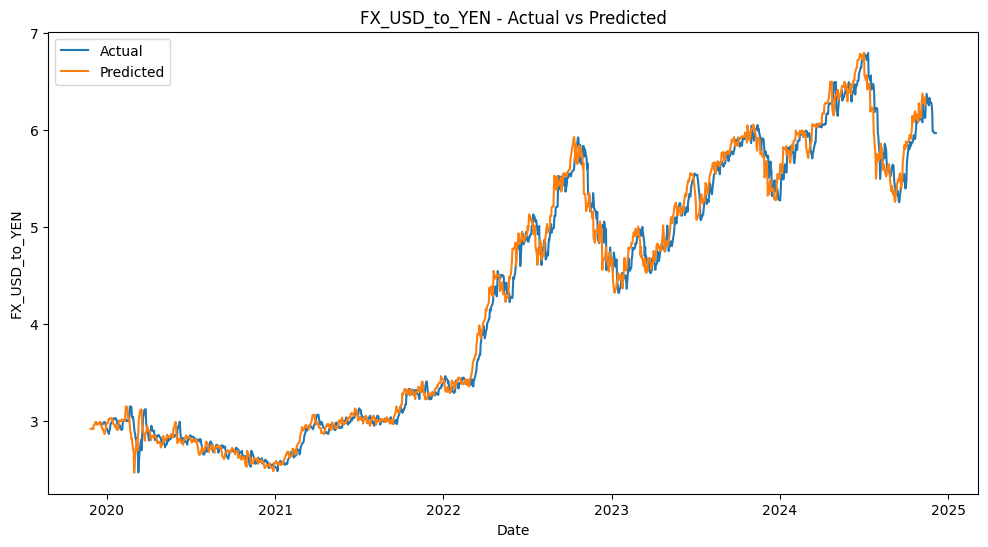

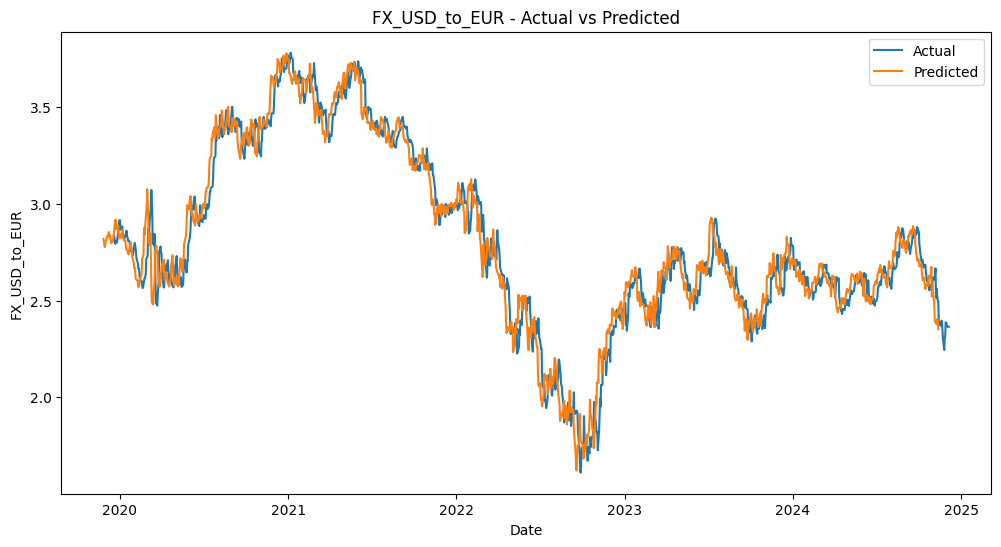

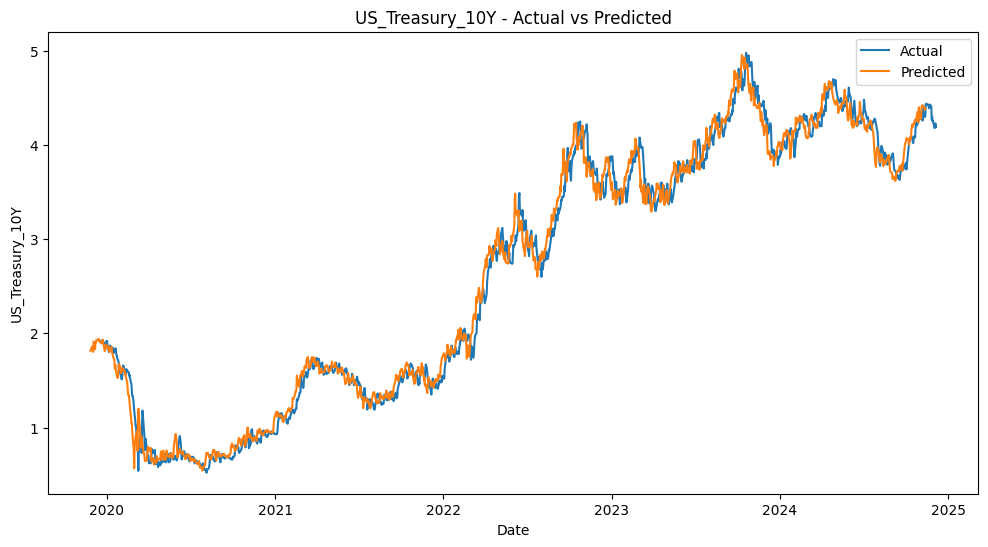

In [ ]:
model.eval()
with torch.no_grad():
  test_predictions = model(X_test_rnn)

test_predictions = test_predictions.numpy()
y_test_np = Y_test.numpy()

test_predictions = test_predictions + lv_test
y_test_np = y_test_np + lv_test

test_predictions_orig = np.zeros_like(test_predictions)
y_test_orig = np.zeros_like(y_test_np)
for i, col in enumerate(data.columns):
  Scalar = scalers[col]
  test_predictions_orig[:, i] = scalers[col].inverse_transform(test_predictions[:, i].reshape(-1, 1)).flatten()
  y_test_orig[:, i] = Scalar.inverse_transform(y_test_np[:, i].reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig, multioutput='raw_values'))
print('\nTest RMSE for each feature:')
for i, col in enumerate(data.columns):
    print(f'{col}: {rmse[i]:.6f}')

# Plotting the graphs (actual vs predicted)
test_dates = data.index[-len(y_test):]
test_dates_ = [x - dt.timedelta(days=23) for x in test_dates]  # Shift test dates
test_dates_ = [x.date() for x in test_dates_]

for i, col in enumerate(data.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_orig[:, i], label='Actual')
    plt.plot(test_dates_, test_predictions_orig[:, i], label='Predicted')
    plt.title(f'{col} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()


### Final Comments on Step 2 RNN Model

Rationale of the selected series:

Our RNN model selects 3 series of 20-years data as our input, including 2 exchange rate series (USD to YEN and USD to EURO), and 1 interest rate series (U.S 10 year treasury). The reason we chose 2 exchange rate series is because we believe that exchange rates are highly correlated, therefore, it's possible for us to find some interesting patterns and trends from the 2 exchange series. We also include a interest rate series in our model because we want to examine if we can observe some patterns between interest rate and exchange rate since we all know empirically interest rate fluctuation will greatly affect exchange rates, furthermore, the 10 year treasury rate proivdes a sense of economic conditions to us, allowing us to see the impact of economic conditions on exchange rates.

Model forecasting ability:

Based on the graphs, we can clearly observe that the model is accurate in terms of its predicting power, it basically predicts the correct trend compared with the actual data. However, we can't just simply conclude that we have a very powerful yet effective model since the RMSE is relatively high and we have fewer hyperparameters.

The toal number of parameters in this model is 3056.

# Step 3 – Long Short Term Memory

Repeat everything from Step 2 but replace everything with LSTMs instead.  Now feed two series into each first layer LSTM.  This means you will push one of the series into both LSTMs. Try once more with a different combination (3 & 3, 3 & 2, 3 & 1, or 2 & 1)

Here we define LSTM model used to build a multi-layer LSTM based on NN.

# We replace RNNs with LSTMs.

Two series are fed into one LSTM (lstm_first_1), and an overlapping series is fed into the second LSTM (lstm_first_2).

The first layer has two LSTMs processing seperate input data.
The second layer has an LSTM combining outputs from first layer for more complex representation.
The third layer is a linear layer with SoftPlus activation with no more than 5 nodes.
The output layer has three nodes with no activation function to produce prediction.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size1=2, input_size2=2, hidden_size=16, hidden_layer_size=2, hidden_nodes_size=5, output_size=3):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.hidden_layer_size = hidden_layer_size

        self.lstm_first_1 = nn.LSTM(input_size1, hidden_size, hidden_layer_size, batch_first=True) #first layer
        self.lstm_first_2 = nn.LSTM(input_size2, hidden_size, hidden_layer_size, batch_first=True)

        self.lstm_second = nn.LSTM(hidden_size * 2, hidden_size, hidden_layer_size, batch_first=True) #second layer

        self.fc_hidden = nn.Linear(hidden_size, hidden_nodes_size)  #third layer with SoftPlus activation
        self.activation_hidden = nn.Softplus()

        self.output_layer = nn.Linear(hidden_nodes_size, output_size)  #output layer

    def forward(self, x):
        x_series1 = x[:, :, :2]  #split input into two LSTM, here is first 2 series
        x_series2 = x[:, :, 1:].contiguous()

        out_first_1, _ = self.lstm_first_1(x_series1) #first layer
        out_first_2, _ = self.lstm_first_2(x_series2)

        #only last time step outputs are passed to the next layer
        out_first_1 = out_first_1[:, -1, :]
        out_first_2 = out_first_2[:, -1, :]

        #connect and pass through second LSTM
        out_second = torch.cat((out_first_1, out_first_2), dim=1).unsqueeze(1)
        out_second, _ = self.lstm_second(out_second)
        out_second = out_second[:, -1, :]

        out_third = self.activation_hidden(self.fc_hidden(out_second))    #third layer

        output = self.output_layer(out_third) #output layer

        return output

Set Model Parameters, and instantiate the model.

In [ ]:
hidden_size = 16
hidden_layer_size = 2
hidden_nodes_size = 5
output_size = 3

lstm_model = LSTMModel(input_size1=2, input_size2=2, hidden_size=hidden_size, hidden_layer_size=hidden_layer_size,
                       hidden_nodes_size=hidden_nodes_size, output_size=output_size)

criterion = nn.MSELoss() #loss function
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

Train the LSTM model for 200 epochs.

We used 100 epochs initially, after observing the big gap between predicted and actual in all three graphs, we decided to increase to 200 epochs.

Use the trained model to predict on test data without gradient computation.

Epoch [20/200], Loss: 0.1584, Test Loss: 0.1558
Epoch [40/200], Loss: 0.0856, Test Loss: 0.0828
Epoch [60/200], Loss: 0.0310, Test Loss: 0.0293
Epoch [80/200], Loss: 0.0106, Test Loss: 0.0098
Epoch [100/200], Loss: 0.0033, Test Loss: 0.0031
Epoch [120/200], Loss: 0.0012, Test Loss: 0.0011
Epoch [140/200], Loss: 0.0008, Test Loss: 0.0008
Epoch [160/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [180/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [200/200], Loss: 0.0007, Test Loss: 0.0007

Test RMSE for each feature:
FX_USD_to_YEN: 0.182620
FX_USD_to_EUR: 0.125815
US_Treasury_10Y: 0.187191


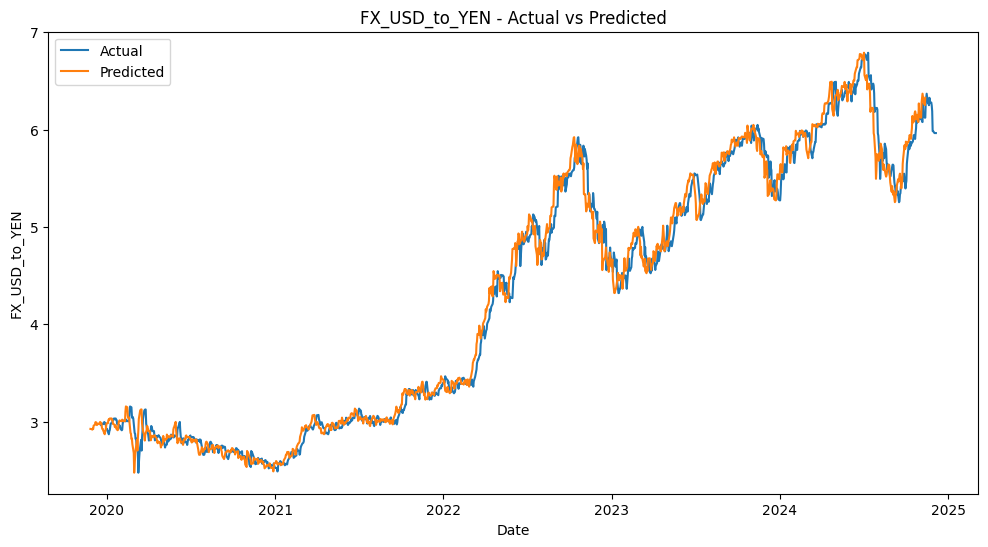

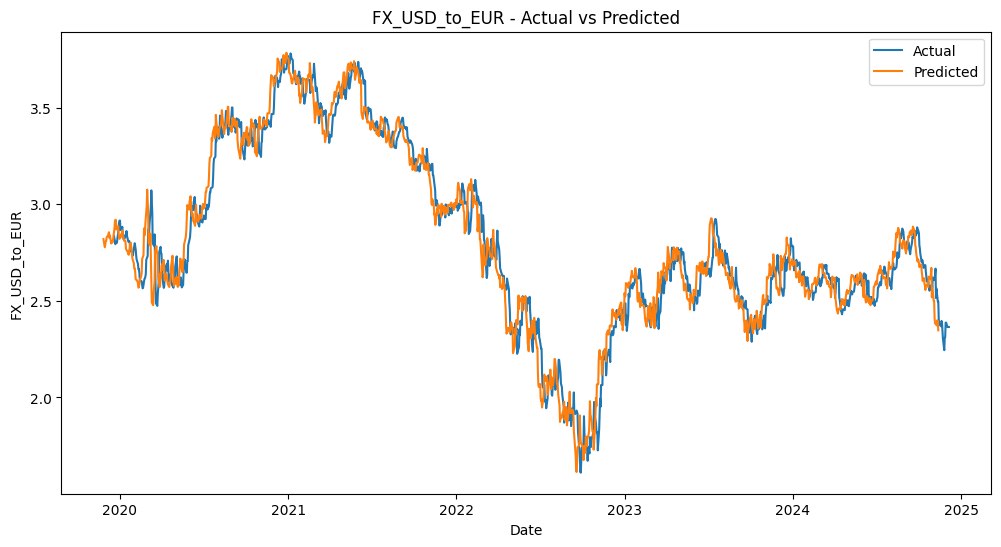

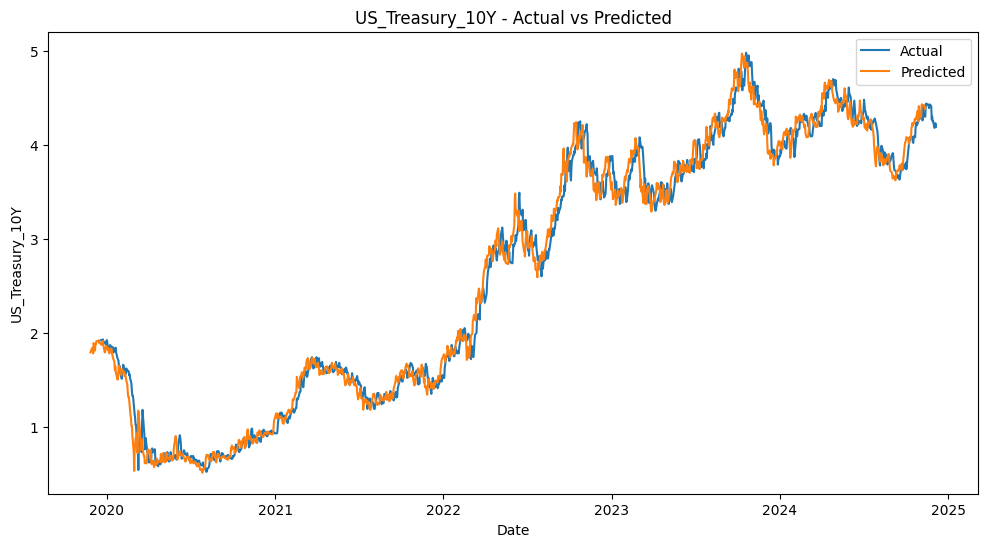

In [ ]:
#training the loop
num_epochs = 200
for epoch in range(num_epochs):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_train_rnn)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        lstm_model.eval()
        with torch.no_grad():
            outputs = lstm_model(X_test_rnn)
            test_loss = criterion(outputs, Y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(X_test_rnn)

test_predictions = test_predictions.numpy() #post-processing for inverse scaling
y_test_np = Y_test.numpy()

test_predictions = test_predictions + lv_test
y_test_np = y_test_np + lv_test

test_predictions_orig = np.zeros_like(test_predictions)
y_test_orig = np.zeros_like(y_test_np)
for i, col in enumerate(data.columns):
    scaler = scalers[col]
    test_predictions_orig[:, i] = scaler.inverse_transform(test_predictions[:, i].reshape(-1, 1)).flatten()
    y_test_orig[:, i] = scaler.inverse_transform(y_test_np[:, i].reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig, multioutput='raw_values')) #calculate RMSE
print('\nTest RMSE for each feature:')
for i, col in enumerate(data.columns):
    print(f'{col}: {rmse[i]:.6f}')

#plot the actual vs predicted values
test_dates = data.index[-len(y_test):]
test_dates_ = [x - dt.timedelta(days=23) for x in test_dates]

for i, col in enumerate(data.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_orig[:, i], label='Actual')
    plt.plot(test_dates_, test_predictions_orig[:, i], label='Predicted')
    plt.title(f'{col} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()


Comments on step 3 output so far:

1 Loss and Test Loss Output: The training loss and test loss decrease consistently, stabilizing at very low values (around 0.0007), indicating good convergence and minimal overfitting.

2 RMSE are 0.182620, 0.125815 and 0.187191 respectively, which are slightly big, but in reasonable range.

3 Three graphs: the predicted values closely follow the actual values in three series, demonstrating good model performance for these features.  The model demonstrate good ability to forecast.

4 There are 5479 parameters in this model.(By using AI to count)

5 The use of hidden size 16 and 2 layers keeps the parameter count reasonable.

# Now, try once more with a different combination (3 & 3, 3 & 2, 3 & 1, or 2 & 1)

# Let's try (3&1) combination:

We adjust the input size for the first layer, so that the first LSTM processes all three series, while the second LSTM processes only one series.

Epoch [20/200], Loss: 0.0798, Test Loss: 0.0789
Epoch [40/200], Loss: 0.0314, Test Loss: 0.0306
Epoch [60/200], Loss: 0.0038, Test Loss: 0.0037
Epoch [80/200], Loss: 0.0008, Test Loss: 0.0008
Epoch [100/200], Loss: 0.0008, Test Loss: 0.0007
Epoch [120/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [140/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [160/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [180/200], Loss: 0.0007, Test Loss: 0.0007
Epoch [200/200], Loss: 0.0007, Test Loss: 0.0007

Test RMSE for each feature:
FX_USD_to_YEN: 0.182712
FX_USD_to_EUR: 0.125716
US_Treasury_10Y: 0.187262


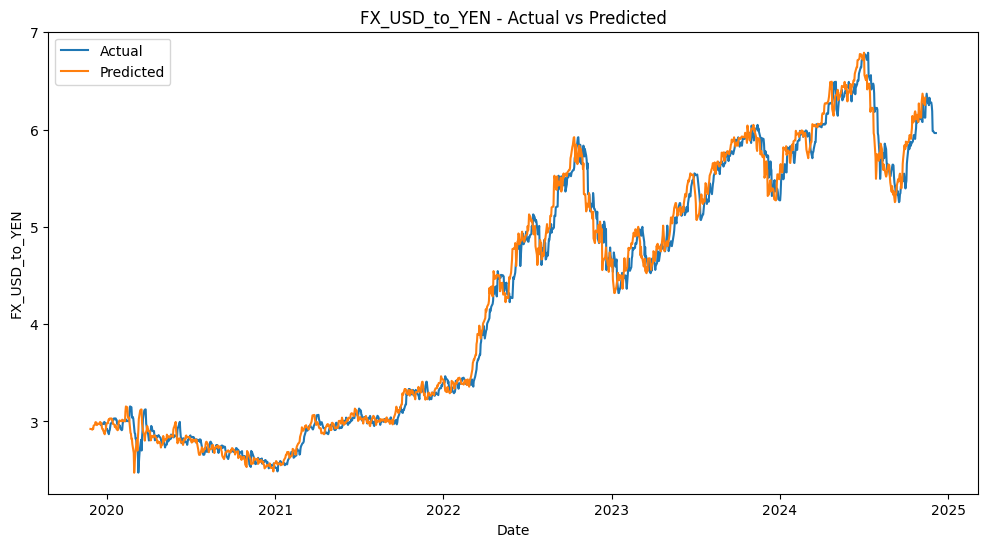

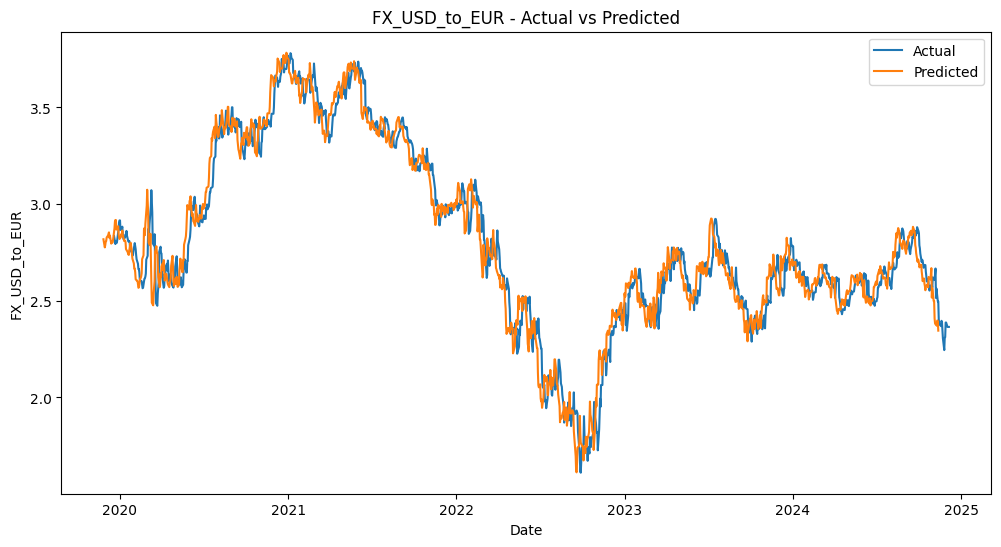

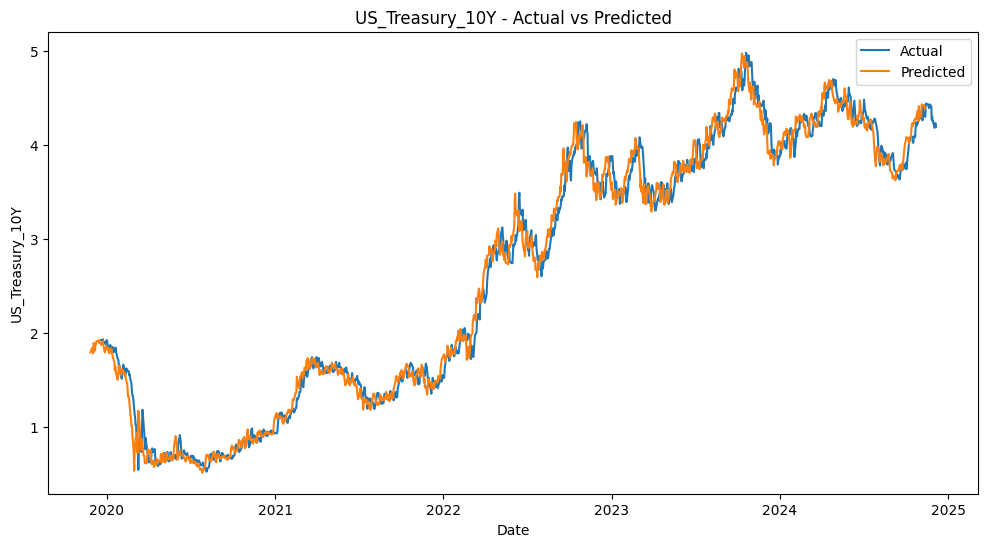

In [ ]:
class LSTMModel_3_1(nn.Module):
    def __init__(self, input_size1=3, input_size2=1, hidden_size=16, hidden_layer_size=2, hidden_nodes_size=5, output_size=3):
        super(LSTMModel_3_1, self).__init__()

        self.hidden_size = hidden_size
        self.hidden_layer_size = hidden_layer_size

        #the first layer with one LSTM for all three series and another for a single series
        self.lstm_first_1 = nn.LSTM(input_size1, hidden_size, hidden_layer_size, batch_first=True)
        self.lstm_first_2 = nn.LSTM(input_size2, hidden_size, hidden_layer_size, batch_first=True)

        #second
        self.lstm_second = nn.LSTM(hidden_size * 2, hidden_size, hidden_layer_size, batch_first=True)

        #third
        self.fc_hidden = nn.Linear(hidden_size, hidden_nodes_size)
        self.activation_hidden = nn.Softplus()

        #output
        self.output_layer = nn.Linear(hidden_nodes_size, output_size)

    def forward(self, x):
        x_all_series = x  #pass all three series into one LSTM
        x_one_series = x[:, :, 2].unsqueeze(-1)  #pass only the third series into the second LSTM

        out_first_1, _ = self.lstm_first_1(x_all_series)
        out_first_2, _ = self.lstm_first_2(x_one_series)

        #only last time step outputs are passed to the next layer
        out_first_1 = out_first_1[:, -1, :]
        out_first_2 = out_first_2[:, -1, :]

        out_second = torch.cat((out_first_1, out_first_2), dim=1).unsqueeze(1)
        out_second, _ = self.lstm_second(out_second)
        out_second = out_second[:, -1, :]

        out_third = self.activation_hidden(self.fc_hidden(out_second))

        output = self.output_layer(out_third)

        return output

#model initialization for (3,1) combination
hidden_size = 16
hidden_layer_size = 2
hidden_nodes_size = 5
output_size = 3

lstm_model_3_1 = LSTMModel_3_1(input_size1=3, input_size2=1, hidden_size=hidden_size, hidden_layer_size=hidden_layer_size,
                               hidden_nodes_size=hidden_nodes_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model_3_1.parameters(), lr=0.001)

#training loop for (3, 1) combination
num_epochs = 200
for epoch in range(num_epochs):
    lstm_model_3_1.train()
    optimizer.zero_grad()
    outputs = lstm_model_3_1(X_train_rnn)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        lstm_model_3_1.eval()
        with torch.no_grad():
            outputs = lstm_model_3_1(X_test_rnn)
            test_loss = criterion(outputs, Y_test)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

lstm_model_3_1.eval()
with torch.no_grad():
    test_predictions = lstm_model_3_1(X_test_rnn)

test_predictions = test_predictions.numpy()
y_test_np = Y_test.numpy()

test_predictions = test_predictions + lv_test
y_test_np = y_test_np + lv_test

test_predictions_orig = np.zeros_like(test_predictions)
y_test_orig = np.zeros_like(y_test_np)
for i, col in enumerate(data.columns):
    scaler = scalers[col]
    test_predictions_orig[:, i] = scaler.inverse_transform(test_predictions[:, i].reshape(-1, 1)).flatten()
    y_test_orig[:, i] = scaler.inverse_transform(y_test_np[:, i].reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig, multioutput='raw_values'))  # Calculate RMSE
print('\nTest RMSE for each feature:')
for i, col in enumerate(data.columns):
    print(f'{col}: {rmse[i]:.6f}')

#Plot actual vs predicted values
test_dates = data.index[-len(y_test):]
test_dates_ = [x - dt.timedelta(days=23) for x in test_dates]

for i, col in enumerate(data.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_orig[:, i], label='Actual')
    plt.plot(test_dates_, test_predictions_orig[:, i], label='Predicted')
    plt.title(f'{col} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()


# There are 5479 parameters in above model.(By using AI to count)

# Final Comments from Step3 LSTM model:

Selected series: we use LSTM instead of RNN, the model still use three series, USD to YEN, USD to EURO, and US 10 year-treasury rate.

Model forecasting ability: the LSTM model effectively captures trend with strong alignment between predicted and actual data. Low RMSE values confirms good forecasting performance, although (3,1) did not significantly outperform than (2,2), suggesting redundancy in the additional series.

Model complexity: there are 5479 parameters for both (2,2) and (3,1), reflecting the increased capacity of LSTMs while remaining efficient. This supports its ability to capture long-term dependencies without overcomplicating the architecture.

Overall, LSTMs demonstrate great performance in time series forecasting. However, the careful input selection is essential, as additional series may not always improve accuracy.